In [1]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import nibabel as nib
import json

In [3]:
def filter_slices_by_threshold(img_slice, concat_slice, threshold=0.01):
    brain_mask_img = img_slice > threshold
    brain_mask_concat = concat_slice > threshold
    brain_volume_img = np.sum(brain_mask_img)
    brain_volume_concat = np.sum(brain_mask_concat)
    return brain_volume_img, brain_volume_concat

def load_patient_data_with_filter(dataset_dir):
    patient_data_dicts = {}
    for patient_id in sorted(os.listdir(dataset_dir)):
        patient_dir = os.path.join(dataset_dir, patient_id)
        if os.path.isdir(patient_dir):
            slice_dict = {}
            for file_name in sorted(os.listdir(patient_dir)):
                if file_name.endswith('.nii.gz'):
                    file_path = os.path.join(patient_dir, file_name)
                    nii_image = nib.load(file_path)
                    image_data = nii_image.get_fdata()

                    if '1.5T' in file_name or '1_5T' in file_name:
                        slice_dict['concat'] = image_data
                    elif '3.0T' in file_name or '3_0T' in file_name:
                        slice_dict['img'] = image_data

            if 'img' in slice_dict and 'concat' in slice_dict:
                img_slices = slice_dict['img']
                concat_slices = slice_dict['concat']
                num_slices = img_slices.shape[2]  # axial slices

                patient_slices = []
                for i in range(num_slices):
                    brain_volume_img, brain_volume_concat = filter_slices_by_threshold(
                        img_slices[:, :, i], 
                        concat_slices[:, :, i], 
                        threshold=0.01
                    )
                    if brain_volume_img > 100 and brain_volume_concat > 100:  
                        patient_slices.append({
                            'img': img_slices[:, :, i][np.newaxis, :, :], 
                            'concat': concat_slices[:, :, i][np.newaxis, :, :],  
                            'cls': 0  
                        })

                if patient_slices:
                    patient_data_dicts[patient_id] = patient_slices
    
    return patient_data_dicts

dataset_dir = "/scratch/Costanza/ADNI_Registration/ADNI_F_SK_Registered" 
patient_data_dicts = load_patient_data_with_filter(dataset_dir)

In [3]:
split_path = os.path.abspath("../Training/patient_splits_nifti.json")

with open(split_path, 'r') as f:
    split_dict = json.load(f)
test_patient_ids = split_dict['test']

test_data = []
slice_numbers = []
test_patient_slices = []
slice_ranges = {}  

for pid in test_patient_ids:
    patient_slices = patient_data_dicts[pid]
    num_slices = len(patient_slices) 
    slice_ranges[pid] = (0, num_slices - 1) 
    for slice_idx, slice_data in enumerate(patient_slices):
        test_data.append(slice_data)
        slice_numbers.append(slice_idx)  
        test_patient_slices.append(pid)

def count_slices_per_patient(test_patient_ids, patient_data_dicts):
    patient_slice_counts = {}
    for pid in test_patient_ids:
        slice_count = len(patient_data_dicts[pid])
        patient_slice_counts[pid] = slice_count
    return patient_slice_counts

patient_slice_counts = count_slices_per_patient(test_patient_ids, patient_data_dicts)

total_slices = sum(patient_slice_counts.values())
print(f"Total number of slices in the test set: {total_slices}")
print("Number of slices per patient and their slice ranges in the test set:")

for pid, count in patient_slice_counts.items():
    start_idx, end_idx = slice_ranges[pid]
    print(f"Patient ID {pid}: {count} slices, Slice range: {start_idx} to {end_idx}")


Total number of slices in the test set: 674
Number of slices per patient and their slice ranges in the test set:
Patient ID 1251: 128 slices, Slice range: 0 to 127
Patient ID 1256: 127 slices, Slice range: 0 to 126
Patient ID 1267: 141 slices, Slice range: 0 to 140
Patient ID 1276: 139 slices, Slice range: 0 to 138
Patient ID 1288: 139 slices, Slice range: 0 to 138


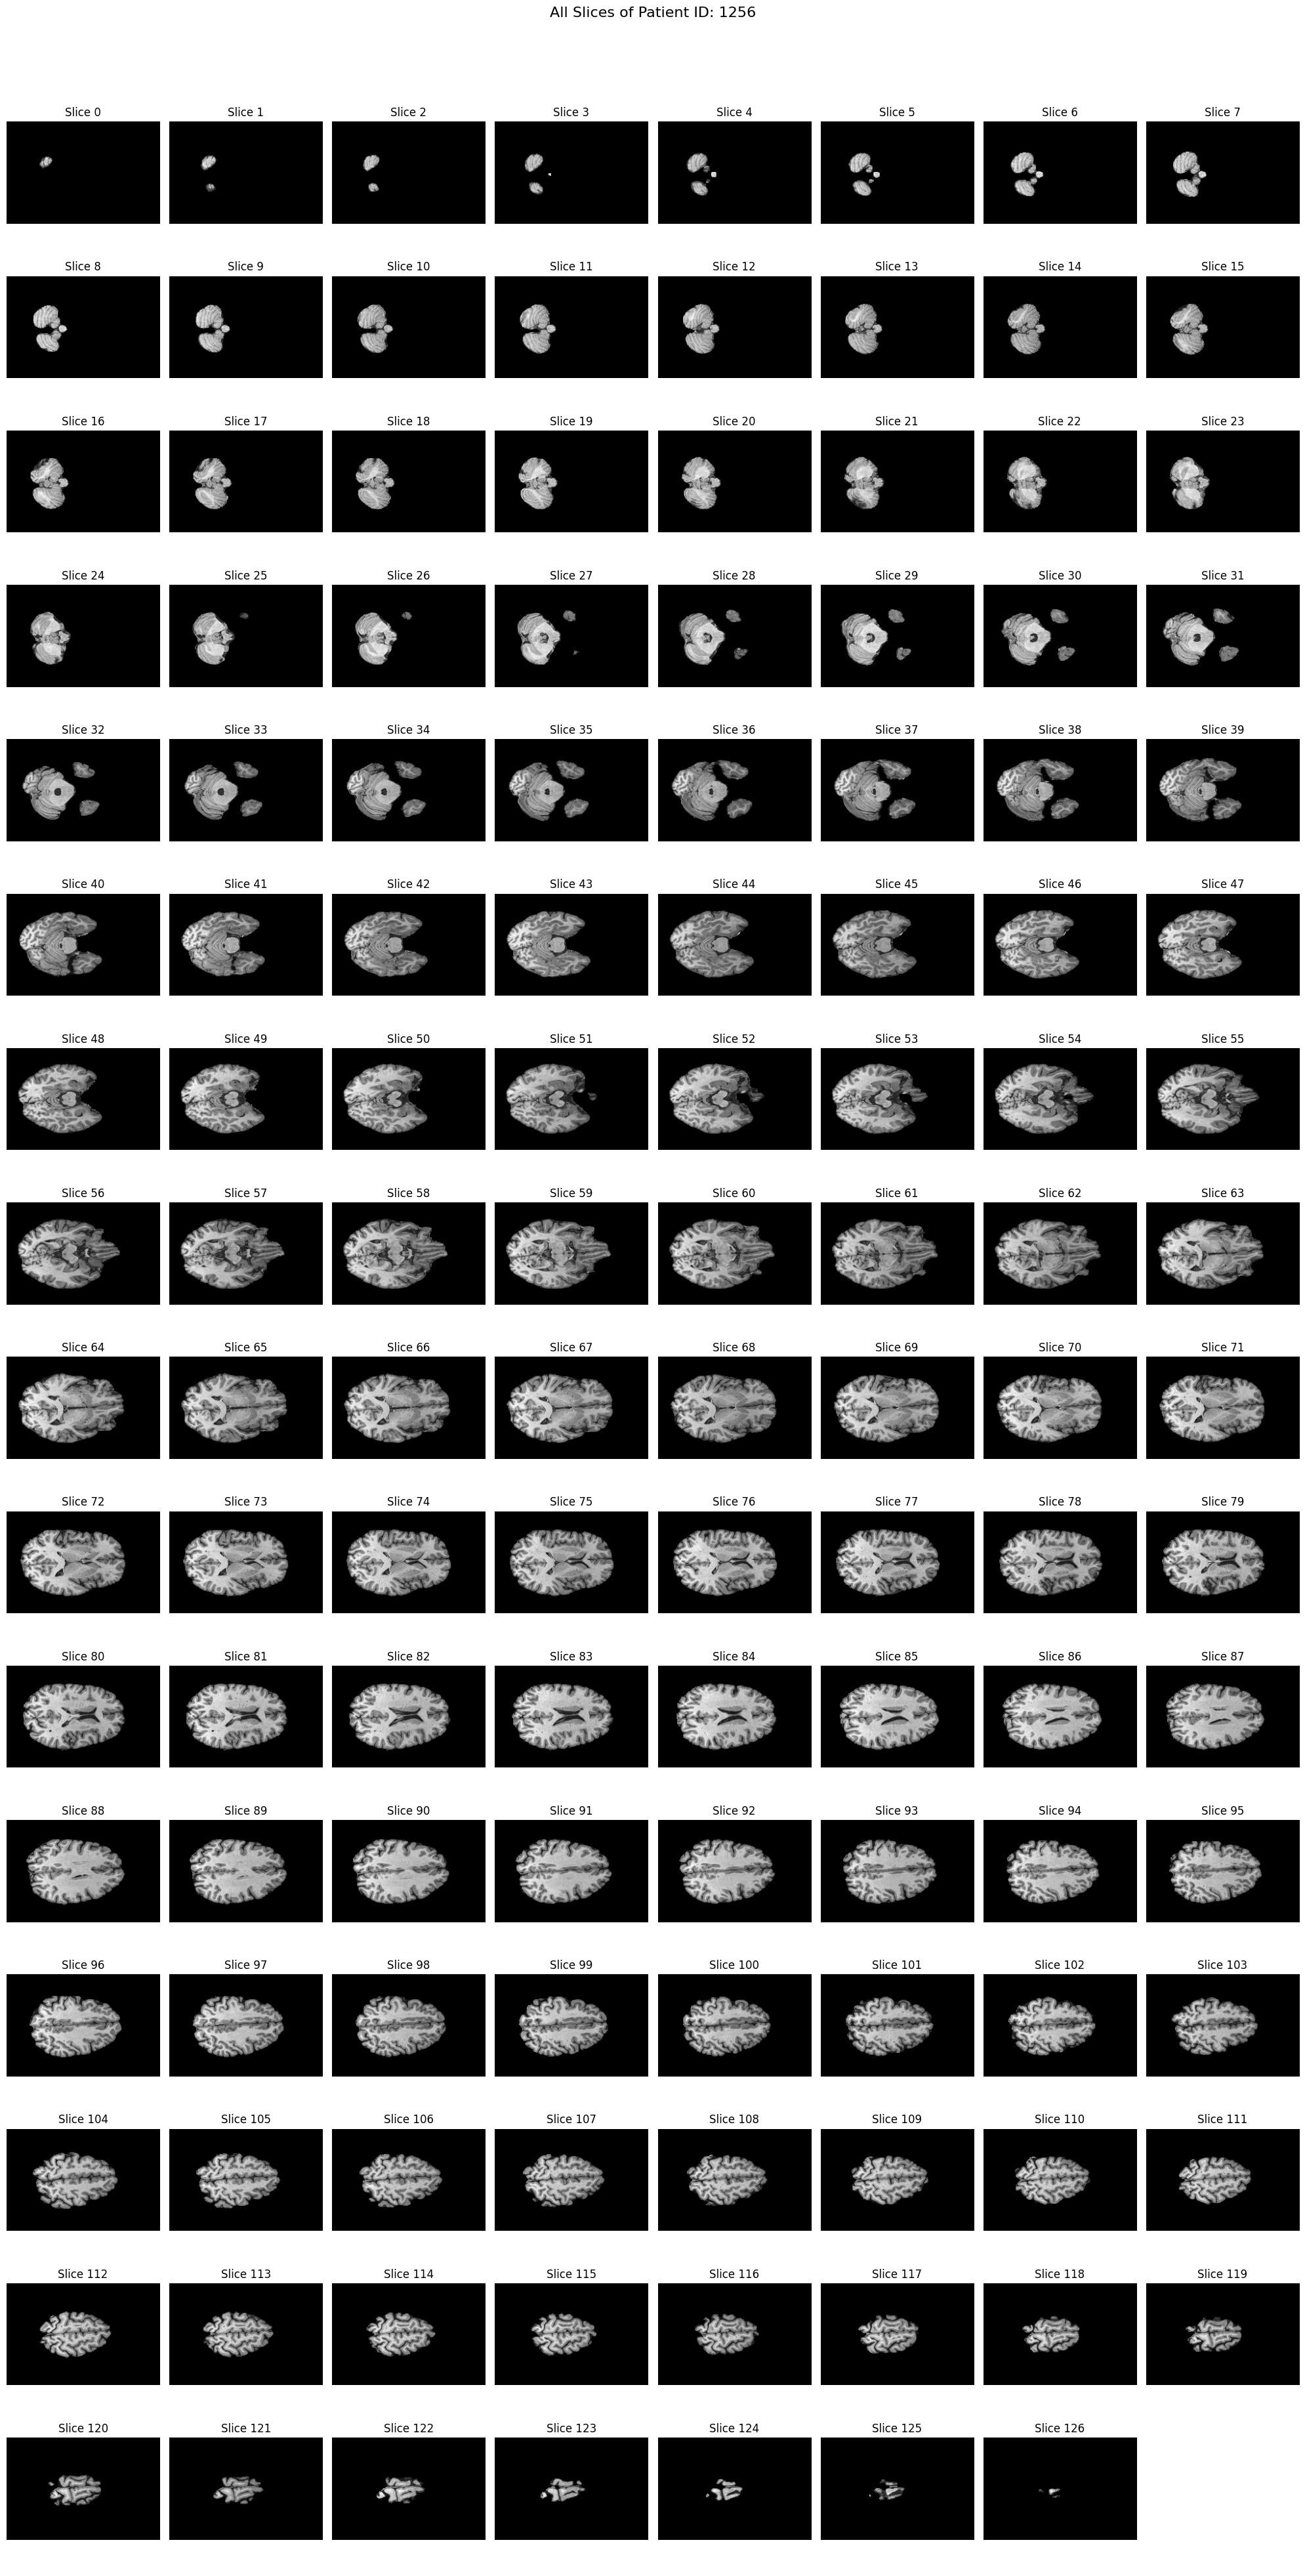

In [4]:
def plot_all_patient_slices(patient_id, patient_data_dicts):
    patient_slices = patient_data_dicts[patient_id]

    total_slices = len(patient_slices)

    cols = 8  
    rows = (total_slices + cols - 1) // cols 

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))

    for i, ax in enumerate(axes.flat):
        if i < total_slices:
            img_slice = patient_slices[i]['img'][0]  
            ax.imshow(img_slice, cmap='gray')
            ax.set_title(f'Slice {i}')
            ax.axis('off')
        else:
            ax.axis('off')  

    plt.suptitle(f'All Slices of Patient ID: {patient_id}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# one patient
example_patient_id = test_patient_ids[1] 
plot_all_patient_slices(example_patient_id, patient_data_dicts)
